In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from tqdm import tqdm

from sklearn.preprocessing import scale, minmax_scale
from scipy.spatial.distance import pdist, squareform
import umap
import umap.plot
import hdbscan

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
sns.set_context('notebook')
sns.set_style('whitegrid')

# Data Collection

In [2]:
fp = Path(r'private/data.csv')

In [3]:
df = pd.read_csv(fp, sep='\t')

In [4]:
df.columns.to_list()

['Unnamed: 0',
 'Unnamed: 0.1',
 'added_at',
 'album.album_type',
 'album.artists.0.external_urls.spotify',
 'album.artists.0.href',
 'album.artists.0.id',
 'album.artists.0.name',
 'album.artists.0.type',
 'album.artists.0.uri',
 'album.available_markets',
 'album.external_urls.spotify',
 'album.href',
 'album.id',
 'album.images.0.height',
 'album.images.0.url',
 'album.images.0.width',
 'album.images.1.height',
 'album.images.1.url',
 'album.images.1.width',
 'album.images.2.height',
 'album.images.2.url',
 'album.images.2.width',
 'album.name',
 'album.release_date',
 'album.release_date_precision',
 'album.total_tracks',
 'album.type',
 'album.uri',
 'artists.0.external_urls.spotify',
 'artists.0.href',
 'artists.0.id',
 'artists.0.name',
 'artists.0.type',
 'artists.0.uri',
 'available_markets',
 'disc_number',
 'duration_ms',
 'explicit',
 'external_ids.isrc',
 'external_urls.spotify',
 'href',
 'id',
 'is_local',
 'name',
 'popularity',
 'preview_url',
 'track_number',
 'type',

In [5]:
features = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'popularity',
    # 'duration_min',
    # 'key'
]

X = df[features]

# Quick playlist creation

In [6]:
selection_df = df[df['danceability'] > df['danceability'].max() * 0.8]
selection_df = selection_df.sort_values(['valence'], ascending=True).head(50)
selection_df[['name', 'artists.name']]

name  \
3263                                          Black Day   
4032                                           2nd Hand   
2045                 Under the Shade of the Willow Tree   
2613                                              Lemon   
3862               Never Come Back - Morgan Geist Remix   
2627                                              Cable   
3182                                                DHL   
1404                             Andromeda (feat. DRAM)   
1885  In Cold Blood (feat. Pusha T) - Twin Shadow Ve...   
243                   Kiss of Life - Psychophonic Remix   
3504                           Sky feat. Luisa Gerstein   
2894                                    Nothing is Safe   
2769                       Quand est-ce que ça s'arrête   
3852                                               Hard   
3424                                    Nerd's Eye View   
3688               Every Color (with Foster The People)   
3602                                         Funky Town   
2028                     Not Alike (feat. Royce Da 5'9)   
3665                           Casual Love - SLVR Remix   
2025                                           Greatest   
3812                                             Outlaw   
4204     About Work The Dancefloor - Gabe Gurnsey Remix   
3364              Those Kinda Nights (feat. Ed Sheeran)   
3993                                   Pool Party Music   
2024                                         The Ringer   
1307                       Darling, Darling, Darling...   
1251                                      HillBilly Man   
4175                    Bossa No Sé (feat. Jean Carter)   
3255               The Lion In My Head (feat. PaulWetz)   
4254             Live Like We’re Dancing (with Georgia)   
2584                                         SICKO MODE   
379                                               Anoid   
4011               Que Calor (feat. J Balvin & El Alfa)   
2186                                    Look No Further   
1400                         Momentz (feat. De La Soul)   
4166                                            Topdown   
3262                                      San Frandisco   
3249                               Ollie - Extended Mix   
2517                                      Old Town Road   
2893                    Blood of the Fang - Single Edit   
2030                                               Fall   
3429                                              Palms   
2252                  im closing my eyes (Feat. shiloh)   
3157                                         Ni un Beso   
1820                                    This Is America   
3939                                          Self-Help   
3279                       Dang! (feat. Anderson .Paak)   
1878                                   Sleep Knows Best   
2026                     Lucky You (feat. Joyner Lucas)   
2582                                           Intruder   

                                         artists.name  
3263                                     ['Monolink']  
4032                                  ['$uicideBoy$']  
2045                                     ['Vague003']  
2613      ['N.E.R.D', 'Rihanna', 'Pharrell Williams']  
3862                      ['Caribou', 'Morgan Geist']  
2627                                     ['Verzache']  
3182                                  ['Frank Ocean']  
1404                                     ['Gorillaz']  
1885                             ['alt-J', 'Pusha T']  
243                                ['Carbon Airways']  
3504                 ['Black Rose', 'Luisa Gerstein']  
2894                                    ['clipping.']  
2769                                      ['Orelsan']  
3852                              ['Rebecca & Fiona']  
3424                                  ['Chris Karns']  
3688         ['Louis The Child', 'Foster The People']  
3602                                   ['Lipps Inc.']  
2028                     ['Eminem

In [21]:
import spotipy
import lib_spotify_app.api_adapter as api_adapter
import json

credential_path = Path(r'private/spotify_credential.json')

with open(str(credential_path)) as file:
    credential = json.load(file)

sp = api_adapter.setup_spotipy(
    credential_path,
    scope=['user-library-read','user-top-read', 'playlist-modify-public', 'playlist-modify-private'],
    cache_path=Path(r'private')
)

In [22]:
r_playlist = sp.user_playlist_create(credential['username'], 'test_danceability_high_valence_low')

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

for track_ids in chunks(selection_df['id'].to_list(), 50):
    sp.playlist_add_items(
        r_playlist['id'],
        track_ids,
    )

# Feature Analysis

In [6]:
X_proc = scale(X)

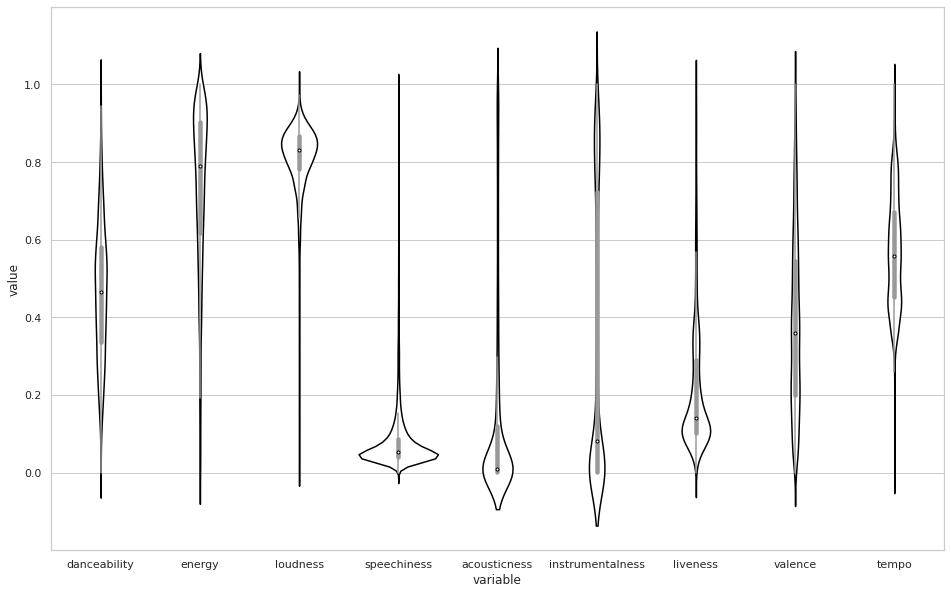

In [7]:
axs = sns.violinplot(x='variable', y='value', data=X.transform(minmax_scale).melt(), inner='box', color='white');
[ax.set_edgecolor('black') for ax in axs.collections];

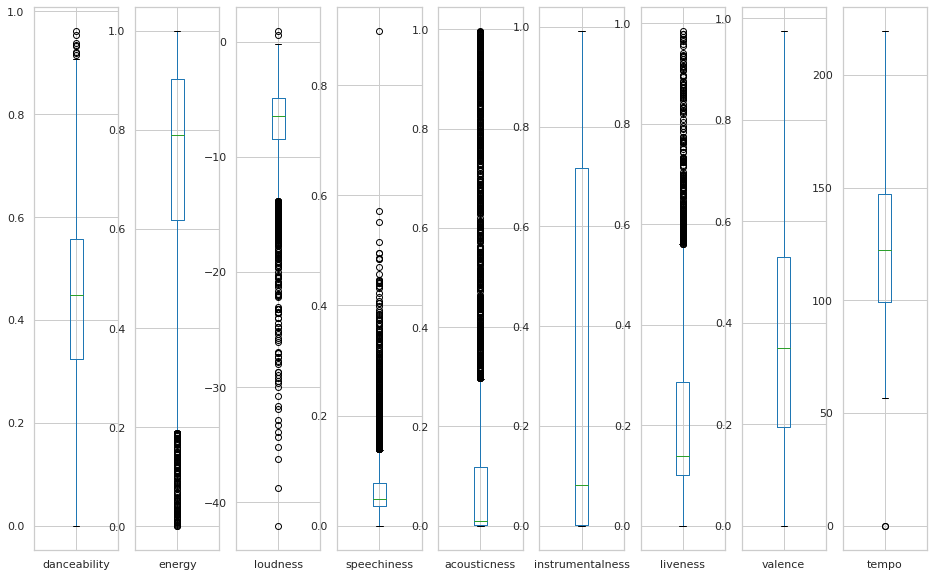

In [8]:
X.plot(subplots=True, kind='box');

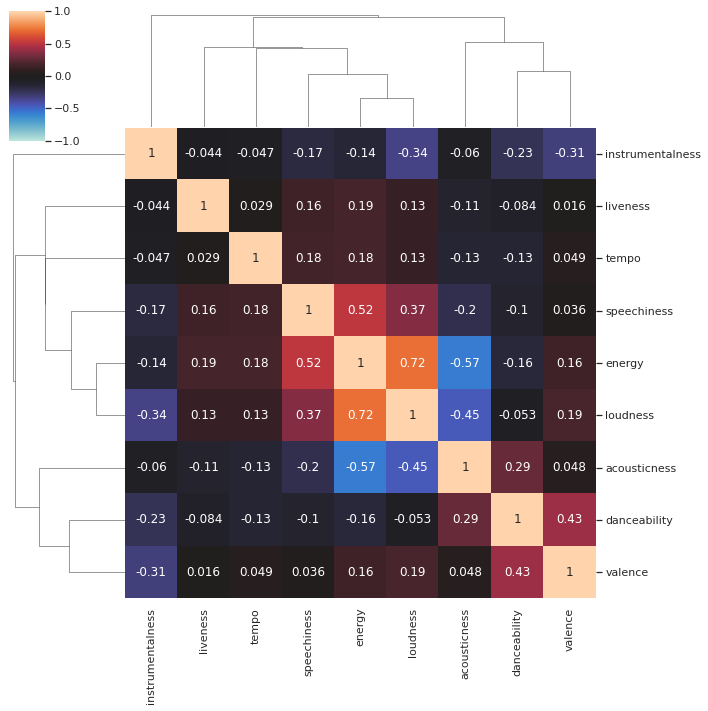

In [9]:
sns.clustermap(X.corr(method='spearman'), annot=True, vmin=-1, vmax=1, center=0);

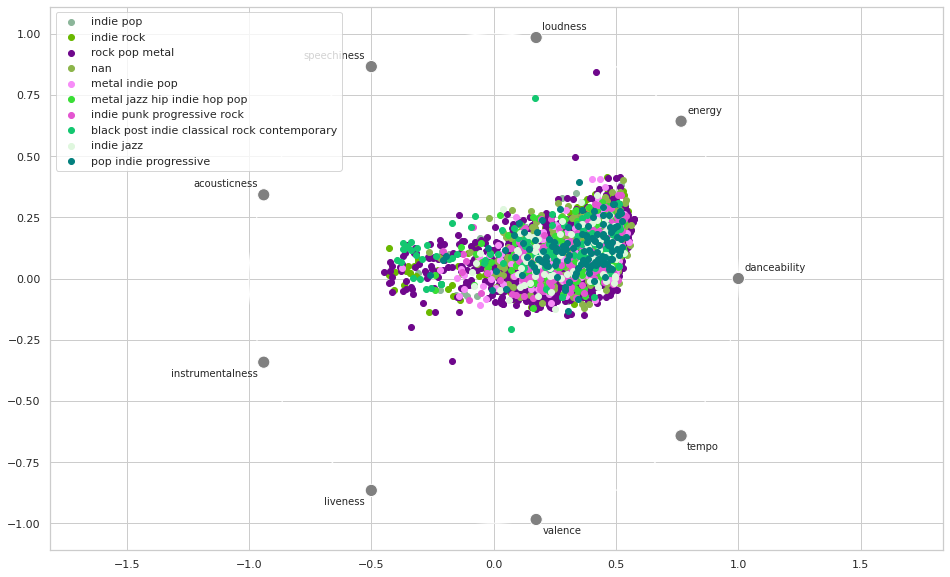

In [10]:
from pandas.plotting import radviz

radviz(
    df[features+['artists.supergenre_1']],
    'artists.supergenre_1'
);

# Feature Importances

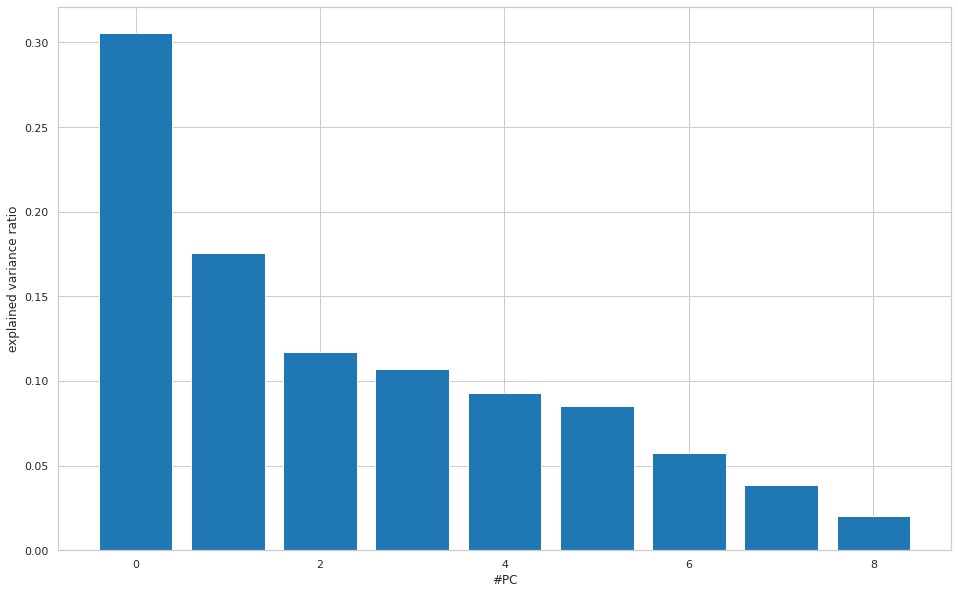

In [11]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42).fit(X_proc)

plt.bar(x=np.arange(0, X.shape[1]), height=pca.explained_variance_ratio_);
plt.xlabel('#PC')
plt.ylabel('explained variance ratio')
plt.show();

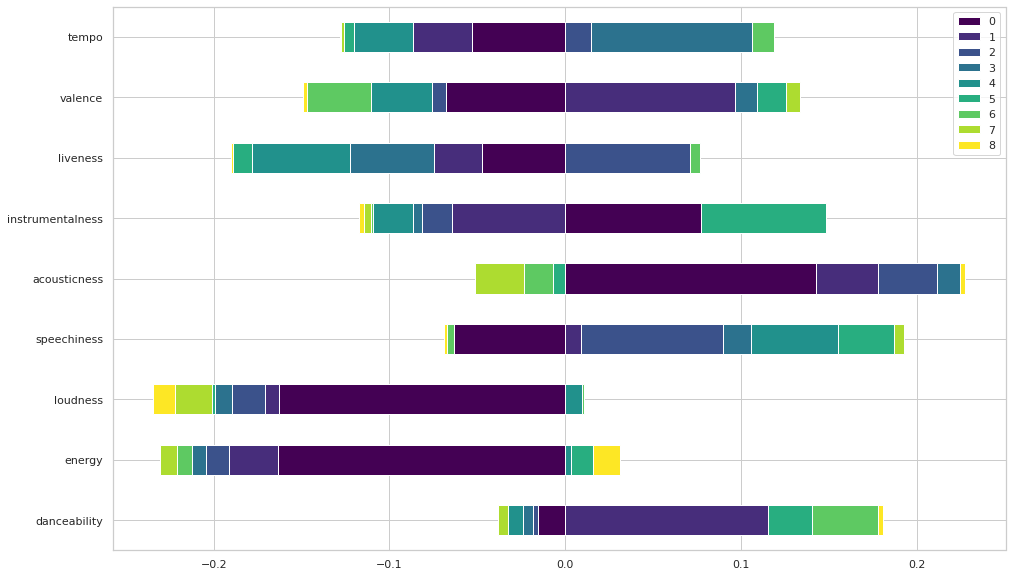

In [12]:
pca_component_weighted = pd.DataFrame(pca.components_, columns=features).T
pca_component_weighted *= pca.explained_variance_ratio_
pca_component_weighted.plot(kind='barh', stacked=True, colormap='viridis');

# Dimensionality Reduction

## Precompute distance matrix

In [13]:
dist_matrix = squareform(pdist(X, metric='mahalanobis'))
dist_matrix.shape

(4316, 4316)

## UMAP Projection

With default value, because some trials were done and shape does not change (n_neighbors distance the points between them)

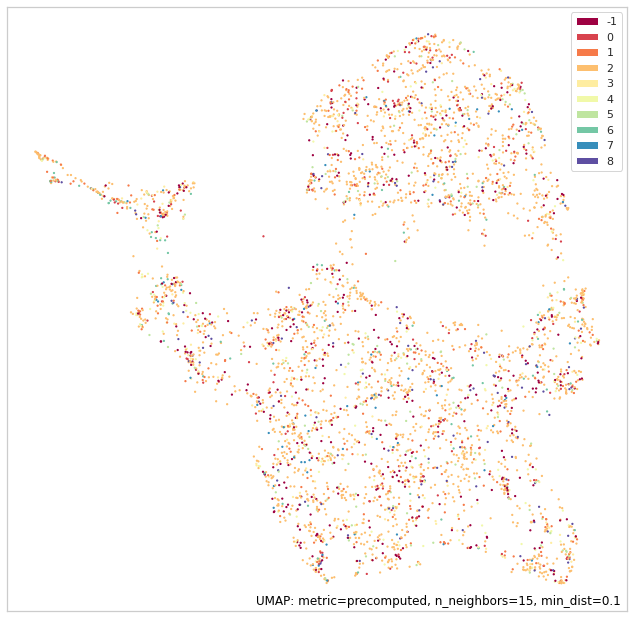

In [15]:
mapper = umap.UMAP(
    random_state=42,
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed',
    n_epochs=500,
    verbose=False,
).fit(dist_matrix)

# print(f'n_neighbors: {n_neighbors}\tmin_dist: {min_dist}')
umap.plot.points(mapper, labels=pd.factorize(df['artists.supergenre_1'])[0]);

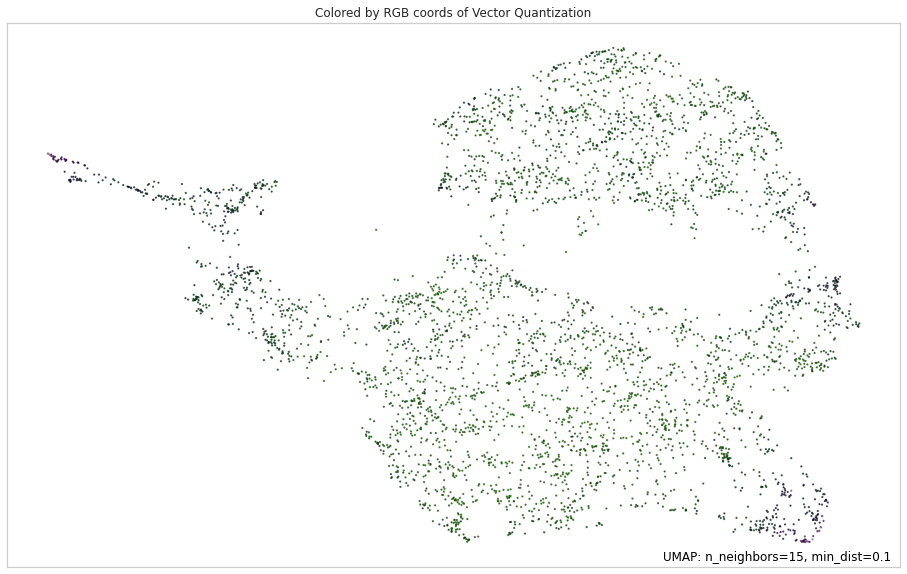

In [16]:
umap.plot.diagnostic(mapper, diagnostic_type='vq');

100%|██████████| 9/9 [00:00<00:00, 30.22it/s]


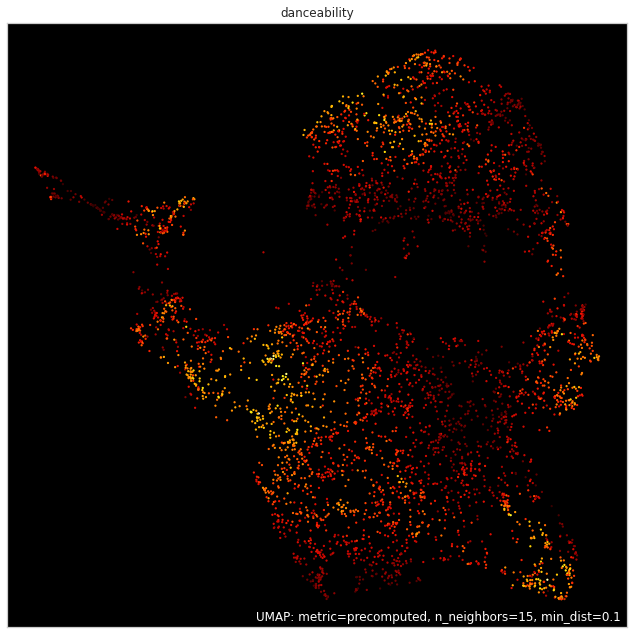

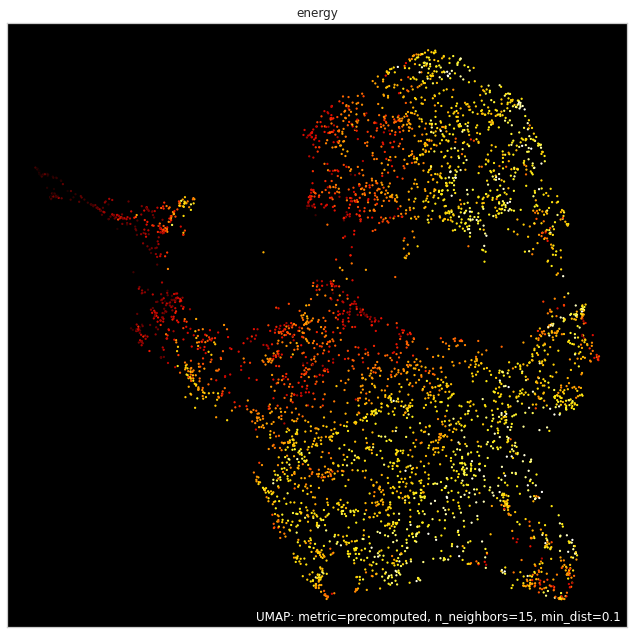

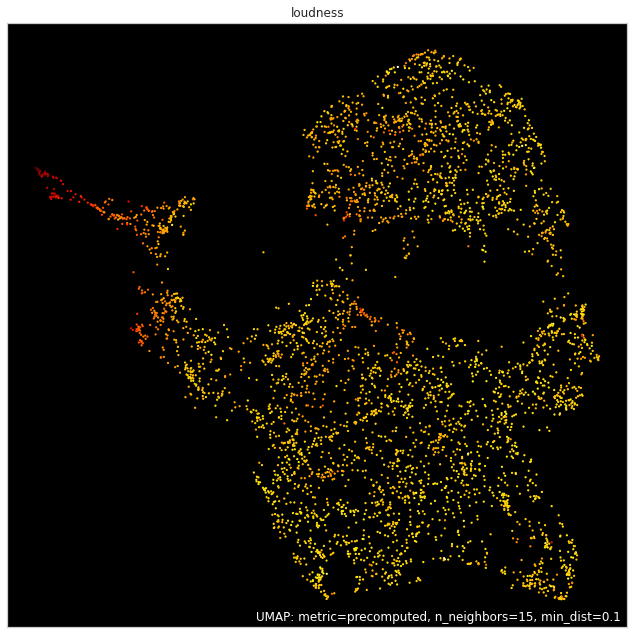

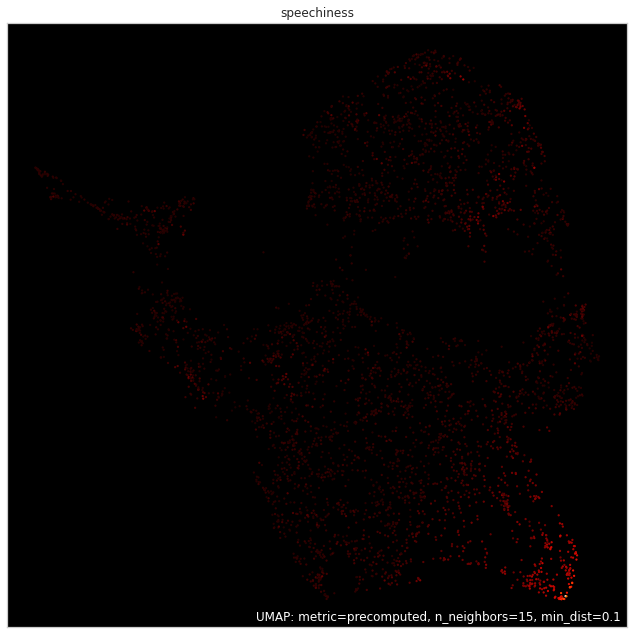

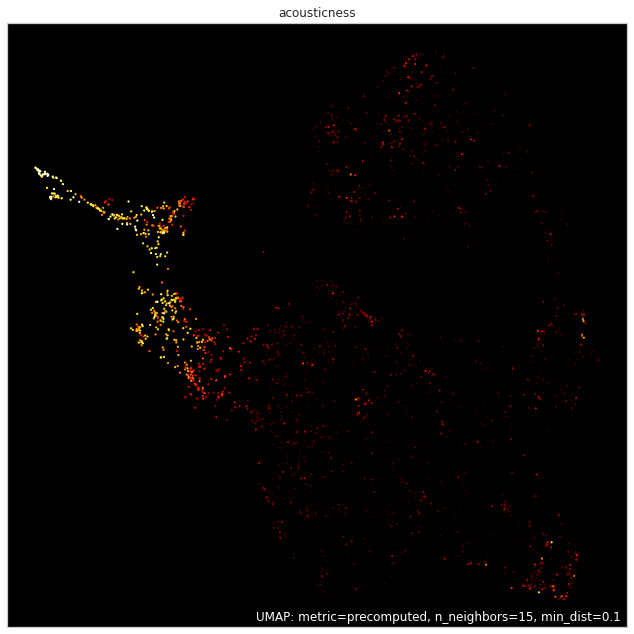

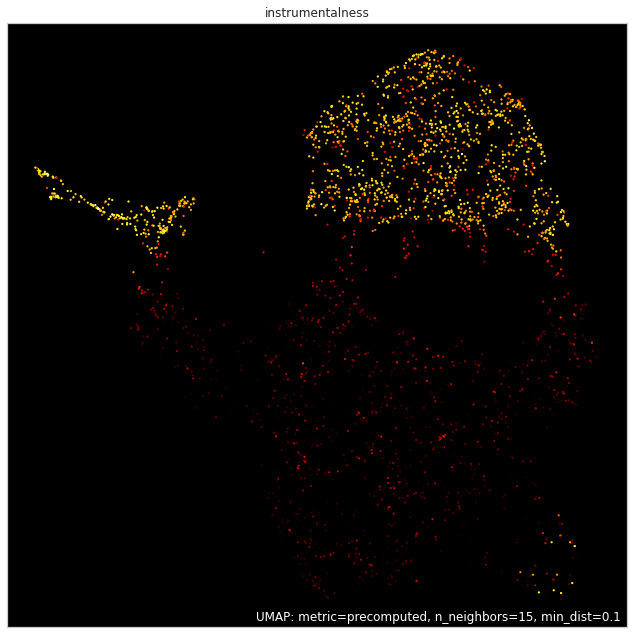

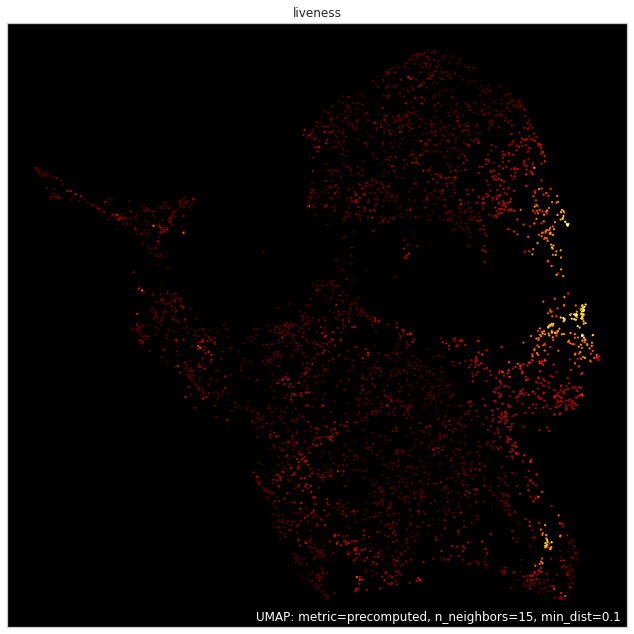

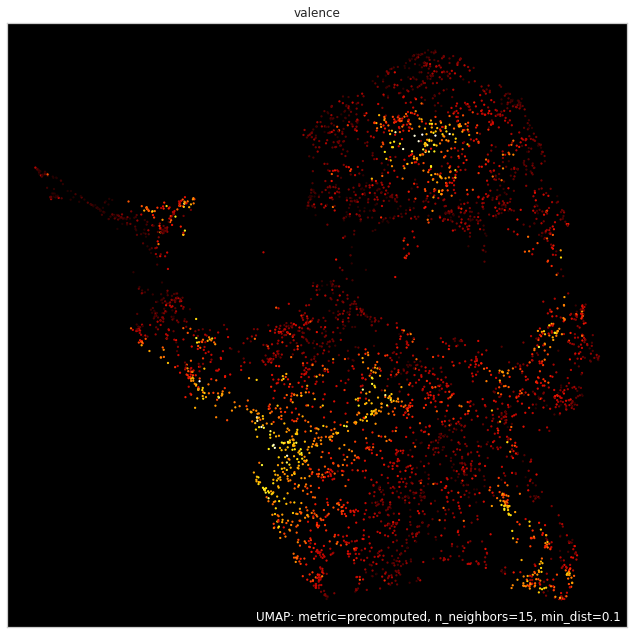

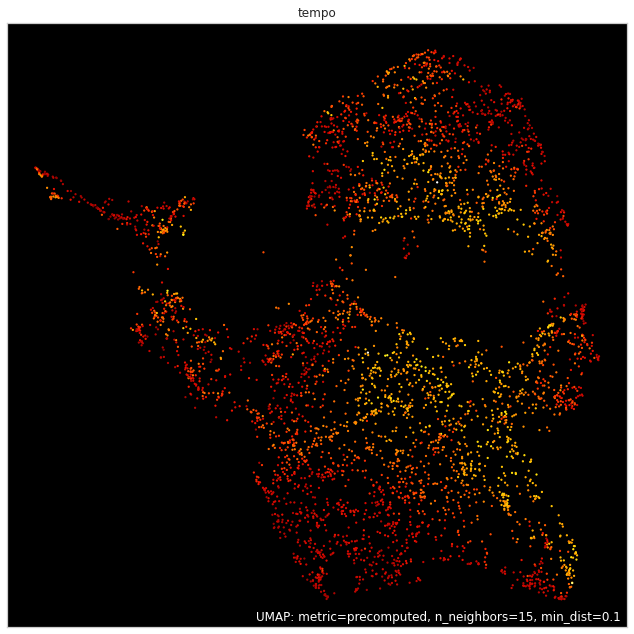

In [17]:
# for k, feat_col in enumerate(tqdm(features)):
#     sns.scatterplot(
#         data=X,
#         x=proj_umap[:,0],
#         y=proj_umap[:,1],
#         hue=df[feat_col],
#         legend=None,
#         edgecolor=None,
#         ax=axes.flatten()[k]
#     ).set_title(feat_col)

for k, feature_value in enumerate(tqdm(X_proc.T)):
    ax = umap.plot.points(
        mapper,
        values=feature_value,
        theme='fire',
    );
    ax.set_title(features[k])

In [18]:
X_map = mapper.transform(dist_matrix)

# Clustering

In [20]:
clusterer_map = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=None,
    cluster_selection_epsilon=0.0,
    gen_min_span_tree=True,
    metric='euclidean',
    core_dist_n_jobs=4,
).fit(X_map)

# clusterer_raw = hdbscan.HDBSCAN(
#     min_cluster_size=50,
#     min_samples=None,
#     cluster_selection_epsilon=0.0,
#     metric='precomputed',
#     core_dist_n_jobs=4,
# ).fit(dist_matrix)

<AxesSubplot:ylabel='distance'>

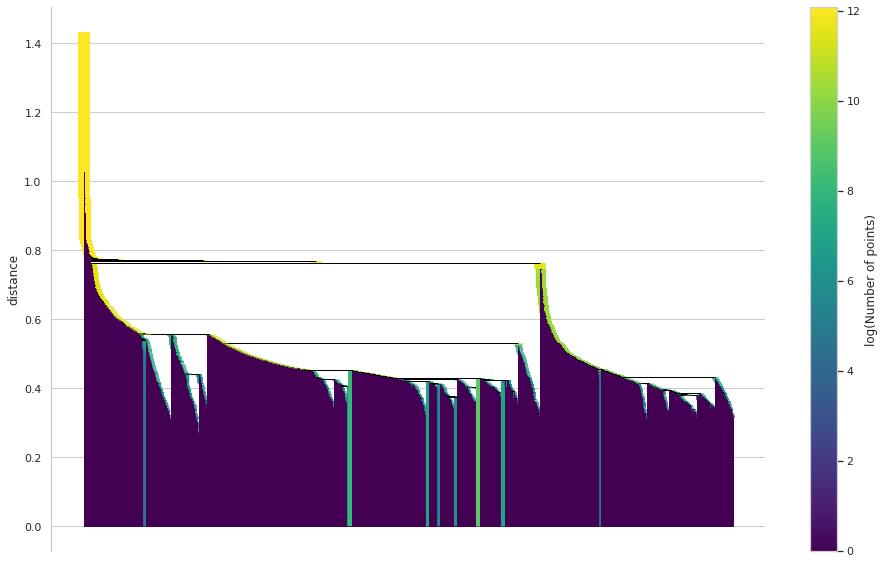

In [21]:
clusterer_map.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

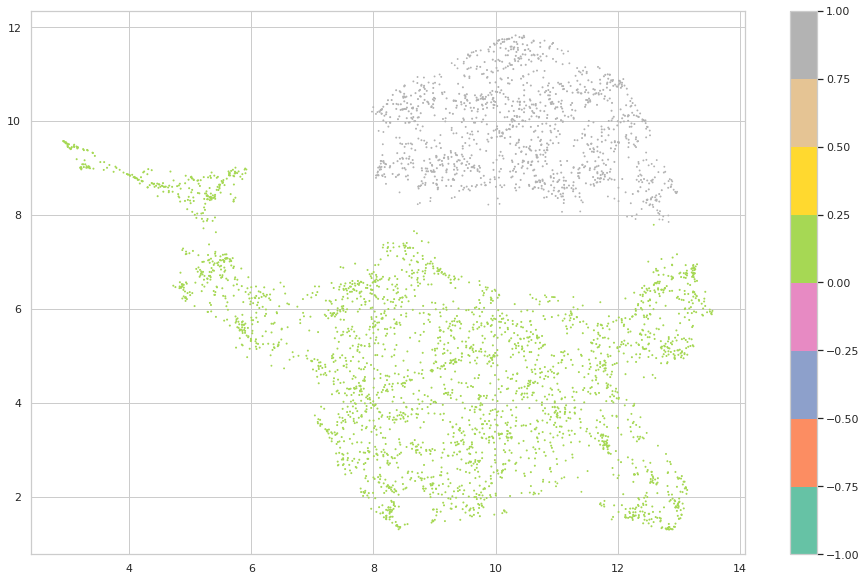

In [22]:
plt.scatter(
    x=X_map[:,0],
    y=X_map[:,1],
    s=clusterer_map.probabilities_,
    c=clusterer_map.labels_,
    cmap='Set2'
)
plt.colorbar();

In [23]:
np.unique(clusterer_map.labels_)

array([-1,  0,  1])

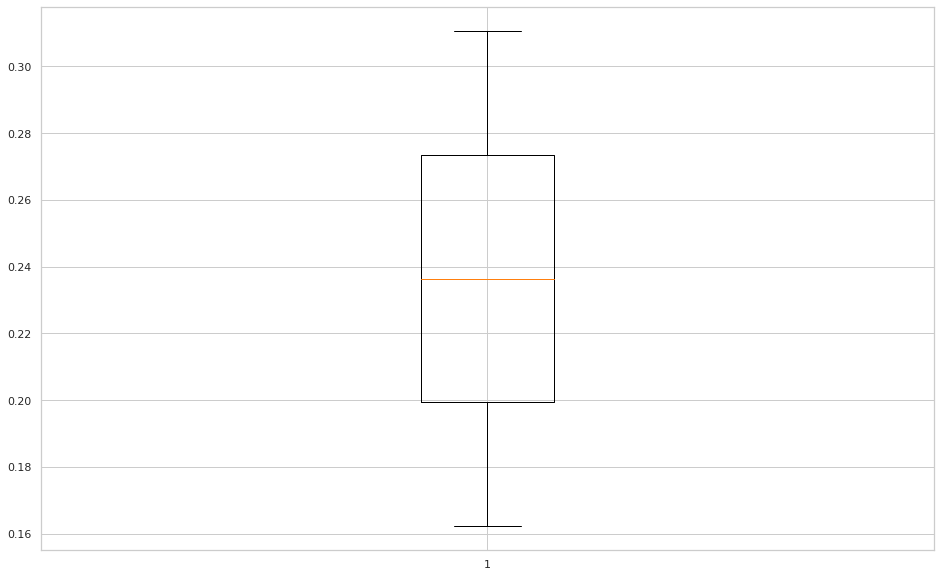

In [24]:
plt.boxplot(clusterer_map.cluster_persistence_);

In [25]:
clusterer_map.relative_validity_

0.006940610168638444

In [26]:
np.unique([e.shape[0] for e in clusterer_map.exemplars_], return_counts=True)

(array([250, 601]), array([1, 1]))

# Create a Spotify Playlist

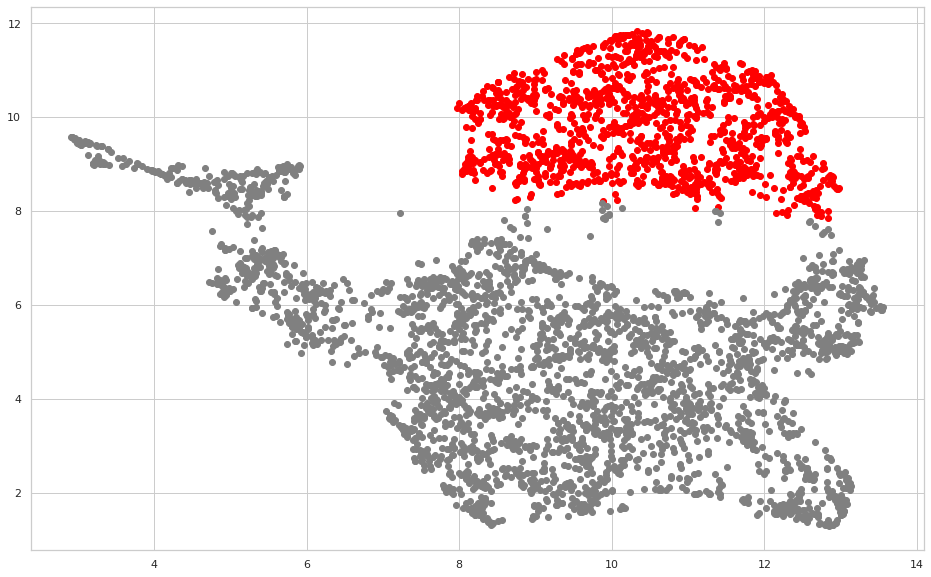

In [69]:
plt.scatter(
    x=X_map[clusterer_map.labels_==1,0],
    y=X_map[clusterer_map.labels_==1,1],
    c='r',
    cmap='Set2'
)
plt.scatter(
    x=X_map[clusterer_map.labels_!=1,0],
    y=X_map[clusterer_map.labels_!=1,1],
    c='grey',
    cmap='Set2'
)
plt.show();

In [71]:
df.loc[clusterer_map.labels_==1][['artists.name', 'name']]

artists.name  \
1                ['Immortal']   
11    ['My Bloody Valentine']   
26             ['Pink Floyd']   
39             ['Pink Floyd']   
41               ['Immortal']   
...                       ...   
4291     ['All Them Witches']   
4296      ['Russian Circles']   
4300     ['Alexandra Savior']   
4302     ['Jordana', 'MELVV']   
4304         ['Mount Kimbie']   

                                                   name  
1                            Tragedies Blows At Horizon  
11                    Only Shallow - Remastered Version  
26    The Happiest Days Of Our Lives - 2011 Remaster...  
39                    Eclipse - 2011 Remastered Version  
41                                      Damned In Black  
...                                                 ...  
4291                                                1X1  
4296                        Quartered - Far Out Version  
4300                                               Howl  
4302                                             Crunch  
4304                            Delta - WXAXRXP Session  

[1281 rows x 2 columns]

In [84]:
import spotipy
import lib_spotify_app.api_adapter as api_adapter
import json

credential_path = Path(r'private/spotify_credential.json')

with open(str(credential_path))) as file:
    credential = json.load(file)

sp = api_adapter.setup_spotipy(
    credential_path,
    scope=['user-library-read','user-top-read', 'playlist-modify-public', 'playlist-modify-private'],
    cache_path=Path(r'private')
)

In [92]:
r_playlist = sp.user_playlist_create(credential['username'], 'test_instrumental')

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

for track_ids in chunks(df.loc[clusterer_map.labels_==1]['id'].to_list(), 50):
    sp.playlist_add_items(
        r_playlist['id'],
        track_ids,
    )

# Optimization

In [7]:
X_map = squareform(pdist(X, metric='mahalanobis'))
X_dist = X_map

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

dist_pipe = FunctionTransformer(
    lambda X: squareform(pdist(X, metric='mahalanobis'))
)

mapper = umap.UMAP(
    random_state=42,
    n_neighbors=15,
    min_dist=0.1,
    metric='precomputed',
    n_epochs=500,
    verbose=False,
)

clusterer_map = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=None,
    gen_min_span_tree=True,
    metric='euclidean',
    core_dist_n_jobs=1,
)

proc = Pipeline([
    ('dist', dist_pipe),
    ('mapper', mapper),
    ('clusterer', clusterer_map)
])

In [77]:
best_proc = bscv.best_estimator_
display(bscv.best_params_)

OrderedDict([('clusterer__min_cluster_size', 100),
             ('clusterer__min_samples', 100),
             ('mapper__min_dist', 0.023149885425506427),
             ('mapper__n_neighbors', 100)])

In [110]:
best_proc = bscv.best_estimator_
display(bscv.best_params_)

OrderedDict([('clusterer__min_cluster_size', 8),
             ('clusterer__min_samples', 18),
             ('mapper__min_dist', 0.004461537963395933),
             ('mapper__n_neighbors', 160)])

In [16]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import ShuffleSplit

search_spaces = {
    'mapper__min_dist': Real(10e-6, 0.99, prior='log-uniform'),
    'mapper__n_neighbors': Integer(5, 1000, prior='log-uniform'),
    'clusterer__min_cluster_size': Integer(5, 1000, prior='log-uniform'),
    'clusterer__min_samples': Integer(5, 1000, prior='log-uniform'),
}

def dbcv(pipe:Pipeline, X):
    return pipe['clusterer'].relative_validity_

base_estimator='GBRT',
bscv = BayesSearchCV(
    proc,
    search_spaces,
    scoring=dbcv,
    n_iter=1000,
    cv=ShuffleSplit(n_splits=1, random_state=42),
    verbose=2,
    return_train_score=True,
    refit=True,
    random_state=42,
    optimizer_kwargs=dict(initial_point_generator='lhs'),
    n_points=4,
    n_jobs=4,
).fit(X)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   27.1s finished
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   20.9s finished
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   18.9s finished
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   20.1s finished
Fitting 1 folds for each of 4 candidates, totalling 4 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapse

In [76]:
r = pd.DataFrame(bscv.cv_results_)\
    .sort_values('mean_train_score', ascending=False)\

r = r.loc[:, r.columns.str.contains('param|mean_train_score')]\
     .drop_duplicates(subset=r.columns[r.columns.str.contains('param_')])

display(r.shape)

r.head(10).style.bar(subset='mean_train_score')

(600, 6)

100%|██████████| 10/10 [01:23<00:00,  8.38s/it]


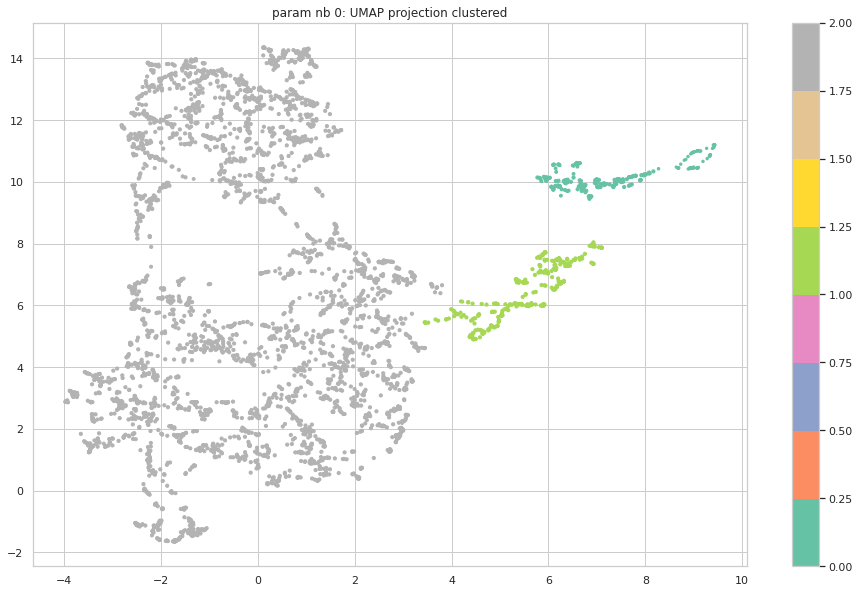

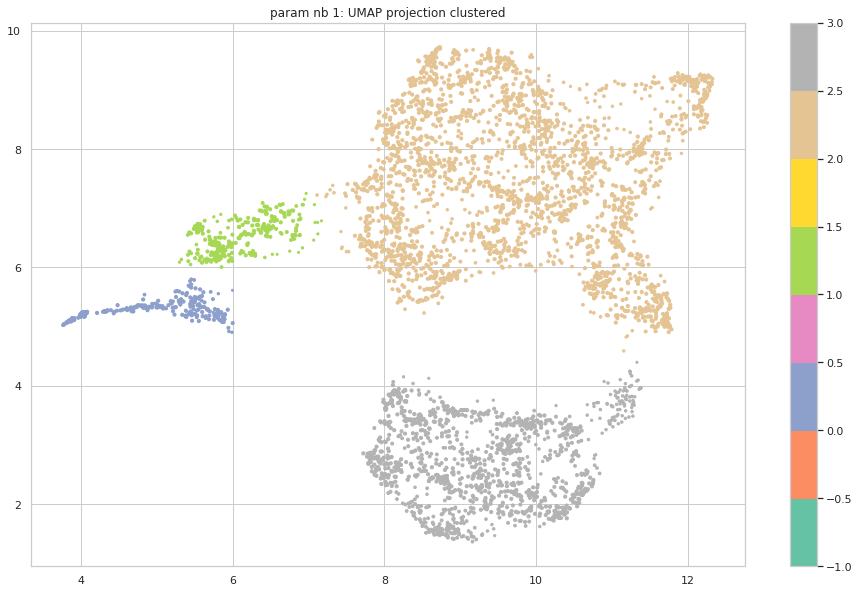

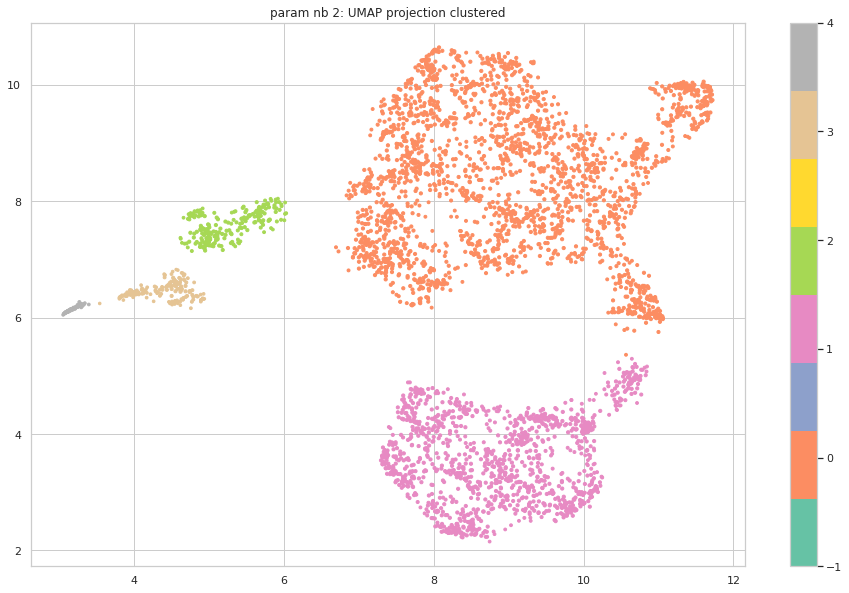

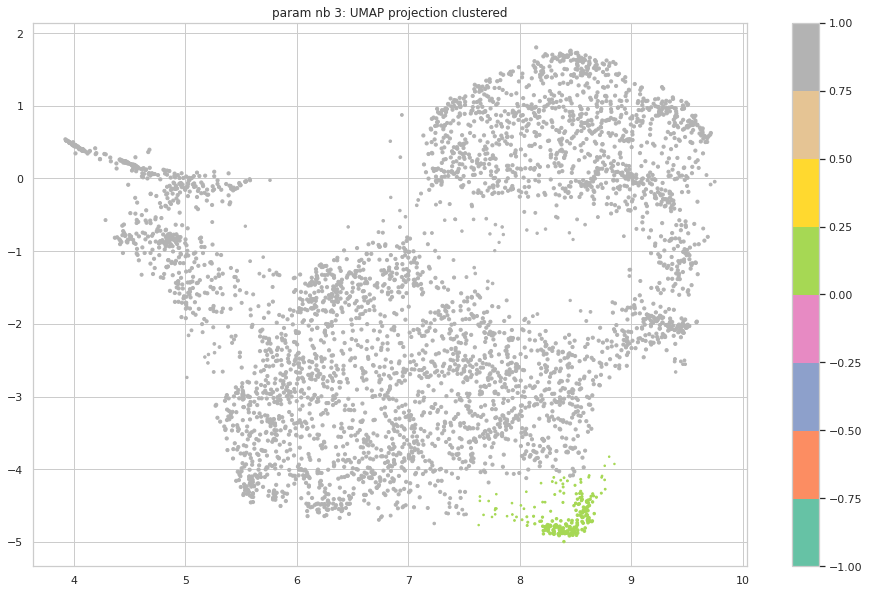

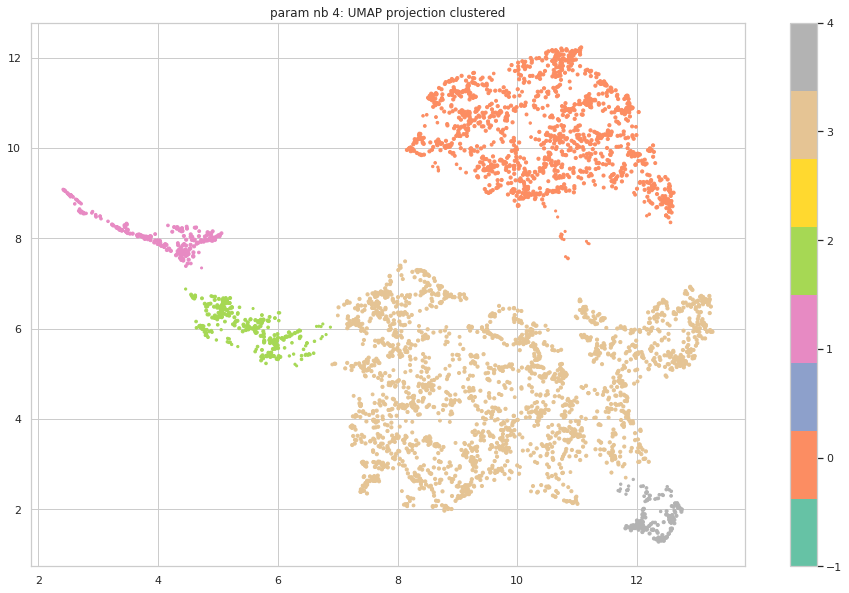

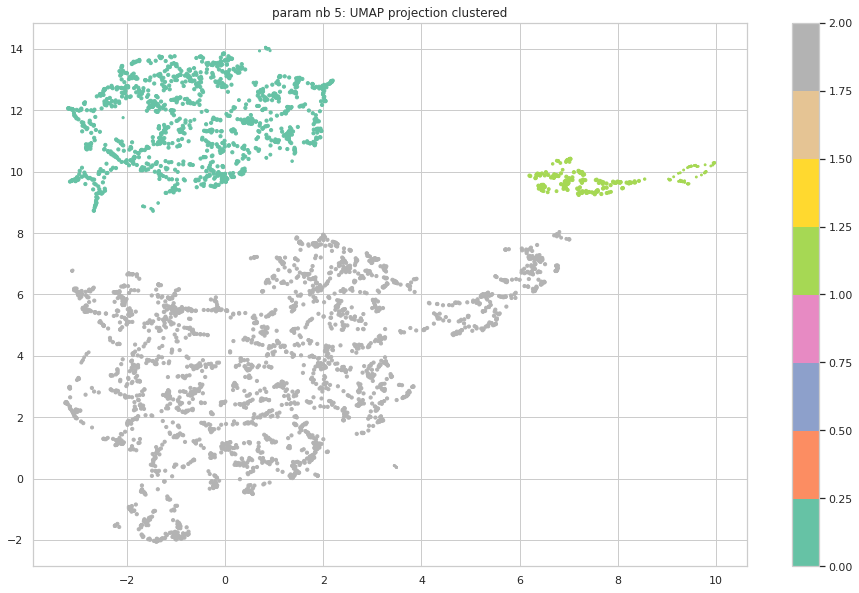

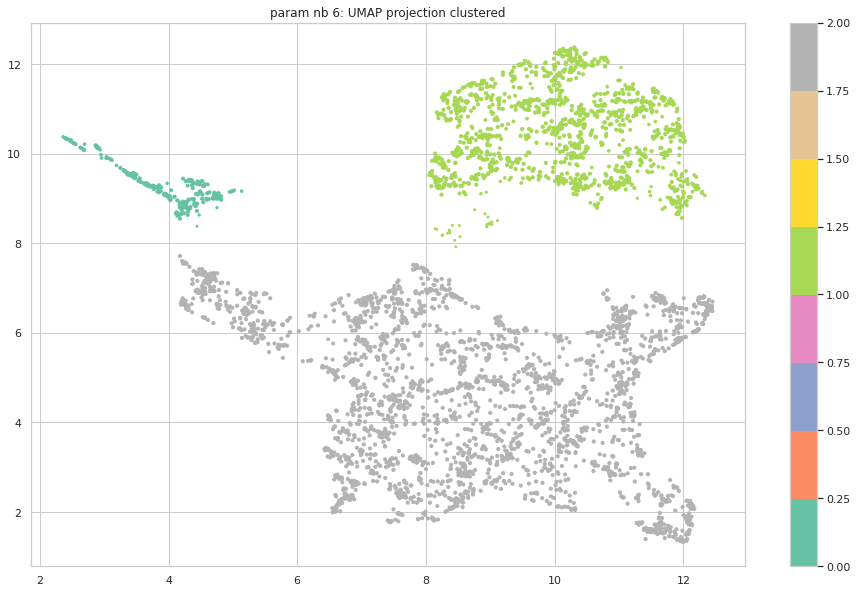

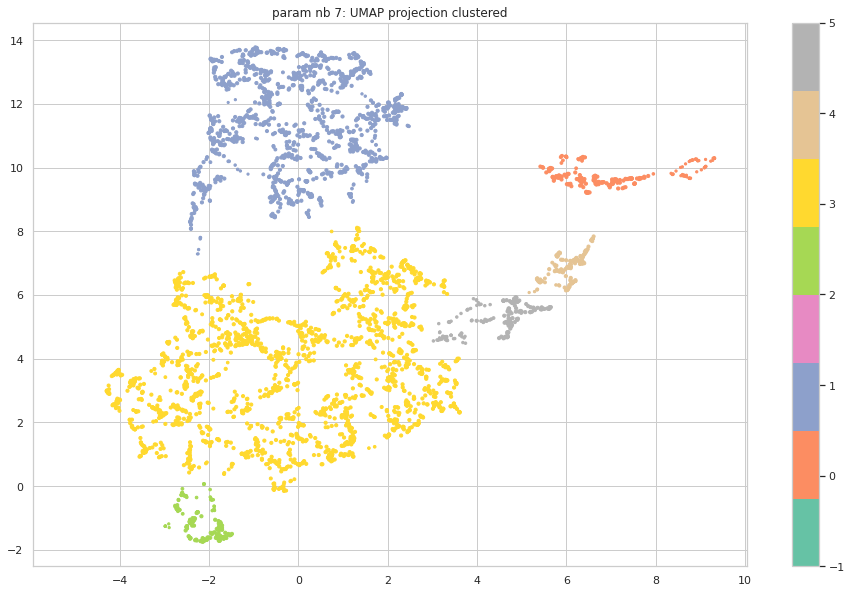

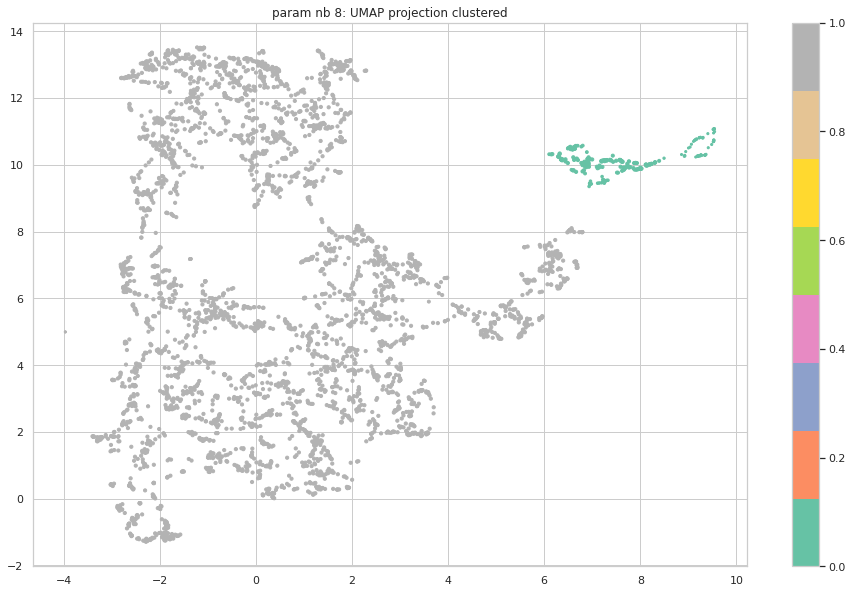

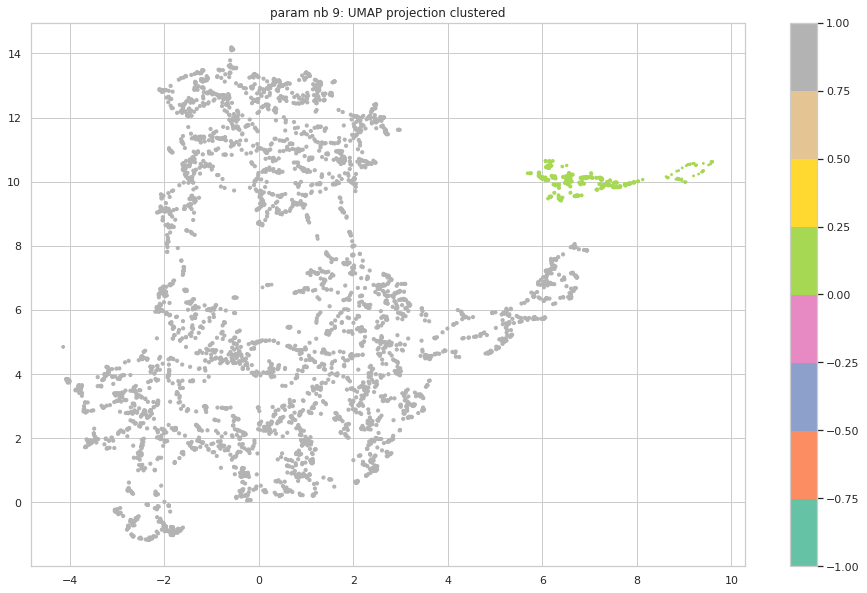

In [79]:
for k, params in enumerate(tqdm(r['params'].iloc[:10])):

    estim = proc.set_params(**params).fit(X)
    X_map = X
    
    for name, estimator in estim.steps[:-1]:
        X_map = estimator.transform(X_map)

    _, ax = plt.subplots()
    plt.scatter(
        x=X_map[:,0],
        y=X_map[:,1],
        s=estim['clusterer'].probabilities_*10,
        c=estim['clusterer'].labels_,
        cmap='Set2'
    )
    plt.colorbar();
    ax.set_title(f'param nb {k}: UMAP projection clustered')

plt.show();

In [78]:
# _, axs = plt.subplots(1, 2)
# axs[0].hist(best_proc['clusterer'].labels_, density=True)
# axs[0].set_title('clusters density')

# sns.histplot(
#     x=best_proc['clusterer'].probabilities_,
#     hue=best_proc['clusterer'].labels_,
#     ax=axs[1],
# )
# axs[1].set_title('samples cluster probability')

# _ = plt.show()

In [35]:
np.geomspace(5, 1000, 3, dtype=int)

array([   5,   70, 1000])

In [37]:
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline

X_dist = squareform(pdist(X, metric='mahalanobis'))

def dbcv(pipe:Pipeline, X=None, y=None):
    return pipe['clusterer'].relative_validity_

def dbcv_normalized(pipe:Pipeline, X=None, y=None):
    return pipe['clusterer'].relative_validity_ / np.log1p(pipe['clusterer'].labels_.max())

def n_clusters(pipe:Pipeline, X=None, y=None):
    return pipe['clusterer'].labels_.max()

n_search = 1

param_spaces = {
    'mapper__min_dist': np.geomspace(10e-6, 0.99, n_search),
    'mapper__n_neighbors': [int(x) for x in np.geomspace(5, 1000, n_search)],
    'clusterer__min_cluster_size': [int(x) for x in np.geomspace(5, 1000, n_search)],
    'clusterer__min_samples': [int(x) for x in np.geomspace(5, 1000, n_search)],
}

r_grid = {
    'params': [],
    'dbcv': [],
    'dbcv_norm': [],
    'n_clusters': [],
}

pipe = Pipeline([
    ('mapper', mapper),
    ('clusterer', clusterer_map)
])

for params in ParameterGrid(param_spaces):
    pipe = pipe.set_params(**params).fit(X_dist)
    r_grid['params'].append(params)
    r_grid['dbcv'].append(dbcv(pipe))
    r_grid['dbcv_norm'].append(dbcv_normalized(pipe))
    r_grid['n_clusters'].append(n_clusters(pipe))

r_grid = pd.DataFrame.from_dict(r_grid)
r_grid

params      dbcv  dbcv_norm  \
0  {'clusterer__min_cluster_size': 5, 'clusterer_...  0.006941   0.001242   

   n_clusters  
0         266

In [44]:
n_search = 3

param_spaces = {
    'mapper__min_dist': np.geomspace(10e-6, 0.99, n_search),
    'mapper__n_neighbors': [int(x) for x in np.geomspace(5, 1000, n_search)],
    'clusterer__min_cluster_size': [int(x) for x in np.geomspace(5, 1000, n_search)],
    'clusterer__min_samples': [int(x) for x in np.geomspace(5, 1000, n_search)],
}

gscv = GridSearchCV(
    Pipeline([('mapper', mapper), ('clusterer', clusterer_map)]),
    param_spaces,
    scoring={'DBCV':dbcv, 'DBCV_norm':dbcv_normalized, 'n_clusters':n_clusters},
    cv = [(slice(None), slice(None))],
    verbose=2,
    return_train_score=False,
    refit=False,
    n_jobs=4,
).fit(X_dist)

pd.DataFrame(gscv.cv_results_)

Fitting 1 folds for each of 625 candidates, totalling 625 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min


KeyboardInterrupt: 

In [ ]:
r_lhs = pd.DataFrame(gscv.cv_results_)\
    .sort_values('mean_train_DBCV', ascending=False)\

r_lhs = r_lhs.loc[:, r_lhs.columns.str.contains('param_|mean_')]\
     .drop_duplicates(subset=r_lhs.columns[r_lhs.columns.str.contains('param_')])

display(r_lhs.shape)

r_lhs.head(20).style.bar(subset=['mean_train_DBCV', 'mean_train_DBCV_norm', 'mean_train_n_clusters'])

In [54]:
import plotly.express as px

for score in ['mean_train_DBCV', 'mean_train_DBCV_norm', 'mean_train_n_clusters']:
    fig = px.parallel_coordinates(
        r_lhs,
        color=score,
        dimensions=r_lhs.columns[r_lhs.columns.str.contains('param_')].to_list(),
        color_continuous_scale=px.colors.diverging.Tealrose,
    )
    fig.show()

In [34]:
best_proc_ = proc()
display(gscv.best_params_)

X_map = X
for name, estimator in best_proc_norm.steps[:-1]:
    X_map = estimator.transform(X_map)

OrderedDict([('clusterer__min_cluster_size', 694),
             ('clusterer__min_samples', 5),
             ('mapper__min_dist', 4.003348996087337e-05),
             ('mapper__n_neighbors', 6)])